In [1]:
#Importing important Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Establish connection with database mysql
conn = pymysql.connect(
    host ='localhost',
    user ='root',
    password ='Mysql@2025',
    database ='loan_db'
)

In [3]:
#import data from database using sql
df_applicant = pd.read_sql("select * from applicantinfo",conn)
df_financial = pd.read_sql("select * from financialinfo",conn)
df_loan = pd.read_sql("select * from loaninfo",conn)

In [4]:
# getting idea about appllication
df_applicant.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed
0,LP001002,Male,No,0,Graduate,No
1,LP001003,Male,Yes,1,Graduate,No
2,LP001005,Male,Yes,0,Graduate,Yes
3,LP001006,Male,Yes,0,Not Graduate,No
4,LP001008,Male,No,0,Graduate,No


In [5]:
 #getting idea about finance
df_financial.head()

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,LP001002,5849,0.0,NaN,360.0,1.0
1,LP001003,4583,1508.0,128.0,360.0,1.0
2,LP001005,3000,0.0,66.0,360.0,1.0
3,LP001006,2583,2358.0,120.0,360.0,1.0
4,LP001008,6000,0.0,141.0,360.0,1.0


In [6]:
 #getting idea about Loan
df_loan.head()

,Loan_ID,Property_Area,Loan_Status
0,LP001002,Urban,Y
1,LP001003,Rural,N
2,LP001005,Urban,Y
3,LP001006,Urban,Y
4,LP001008,Urban,Y


In [7]:
#Close the sql connection
conn.close()

In [8]:
# Merge into a single dataframe
df = df_applicant.merge (df_financial, on ='Loan_ID').merge(df_loan, on ='Loan_ID')
df = df.drop('Loan_ID', axis = 1)


In [9]:
#Check the first 5 records
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [10]:
# Quick check of the data retrieved
print('Shape:',df.shape)
print('Row:', df.shape[0])
print('cilumns:',df.shape[1])

Shape: (614, 12)
Row: 614
cilumns: 12


In [11]:
#Quick EDA / sanity checks
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB


In [12]:
df.isnull().sum().sort_values(ascending=False)

Credit_History       50
Self_Employed        32
LoanAmount           22
Dependents           15
Loan_Amount_Term     14
Gender               13
Married               3
Education             0
CoapplicantIncome     0
ApplicantIncome       0
Property_Area         0
Loan_Status           0
dtype: int64

In [13]:
df.duplicated().sum()

np.int64(0)

In [14]:
# target distribution
print(df['Loan_Status'].value_counts(normalize=True))

Loan_Status
Y    0.687296
N    0.312704
Name: proportion, dtype: float64


In [15]:
# Create simple features
df['Dependents'] = df['Dependents'].replace('3+', '3')
df['Dependents'] = df['Dependents'].astype(float)

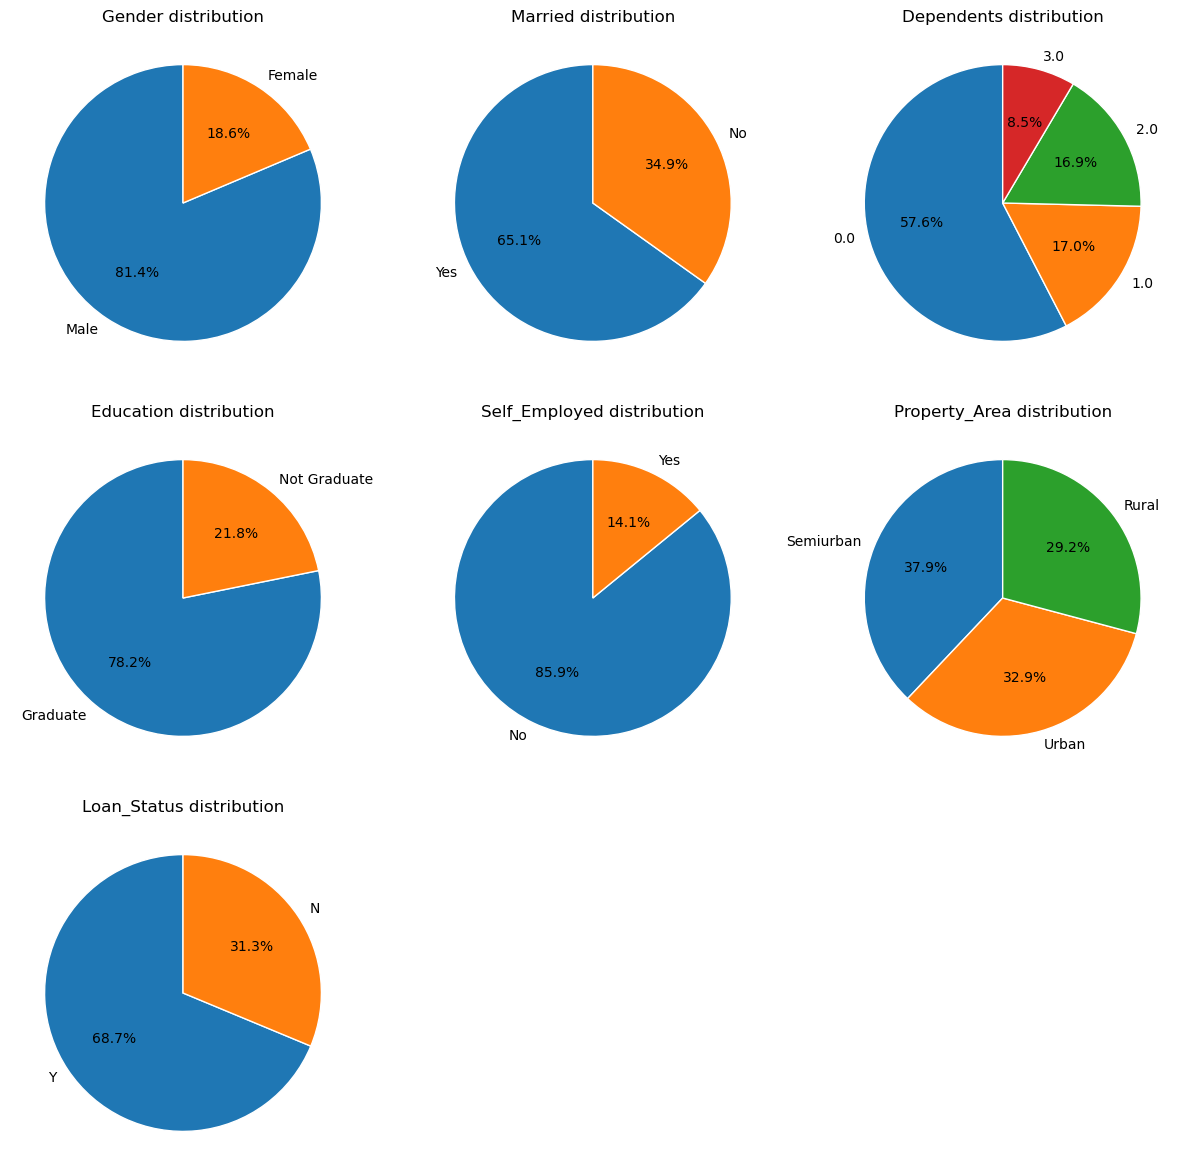

In [16]:
# list of categorical columns in loan dataset
categorical_features = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area','Loan_Status']

# number of subplots
n = len(categorical_features)
ncols = 3   # adjust layout (3 per row is usually neat)
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 4*nrows))

for i, col in enumerate(categorical_features):
    ax = axes[i // ncols, i % ncols]
    df[col].value_counts().plot.pie(
        autopct='%1.1f%%', ax=ax, startangle=90, 
        wedgeprops={'linewidth':1, 'edgecolor':'white'}
    )
    ax.set_ylabel('')
    ax.set_title(f'{col} distribution')

# hide empty subplot slots if any
for j in range(i+1, nrows*ncols):
    fig.delaxes(axes[j//ncols, j%ncols])

plt.tight_layout()
plt.show()


In [17]:
# numeric features
numeric_features = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History']
# categorical features
categorical_features = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area']


In [18]:
#Preprocessing
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())   # scaler useful for logistic regression
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [19]:
# Use a simpler model to start
models = {
    'RandomForestClassifier': RandomForestClassifier(n_estimators=200, max_depth=8, min_samples_leaf=10,random_state=42, n_jobs=-1),
    'LogisticRegression': LogisticRegression(max_iter=2000)
}

In [20]:
#Pipeline
pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf', clf)
])

NameError: name 'clf' is not defined

In [ ]:
# train / test split
X = df.drop(columns=['Loan_Status'])  # replace
y = df['Loan_Status'].map({'Y':1,'N':0})  # if encoded like that

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, stratify=y, random_state=42)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
# Evaluate the model
best_model_name = None
best_score = -np.inf
best_pipeline = None

for name, reg in models.items():
    pipeline = Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('regressor', reg)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    r2 = np.round(metrics.r2_score(y_test, y_pred), 3)
    print(f"\n{name} Results :")
    print(f"R2 Score : {r2 : .3f}")
    print('\nClassification report:\n', classification_report(y_test, y_pred))
    if r2 > best_score:
        best_score = r2
        best_model_name = name
        best_pipeline = pipeline

In [ ]:
# save the best model
import pickle
final_model = name  
with open('best_model.pkl','wb') as f:
    pickle.dump(final_model, f)
